# Exploration of LIMEtree explanations

In [4]:
import os

_base_path = ('https://raw.githubusercontent.com/fat-forensics/resources/'
              'master/surrogates_overview/scripts/{}')
_scripts = ['__init__.py', 'image_classifier.py', 'imagenet_label_map.py']
! mkdir -p scripts
for i in _scripts:
    i_ = _base_path.format(i)
    if not os.path.exists(f'scripts/{i}'):
        ! wget $i_ -O scripts/$i

! mkdir -p _figures

In [145]:
# NBVAL_IGNORE_OUTPUT
import fatf

import fatf.utils.data.instance_augmentation as fatf_augmentation
import fatf.utils.models.processing as fatf_processing

import fatf.utils.data.segmentation as fatf_segmentation
import fatf.utils.data.occlusion as fatf_occlusion

import scripts.image_classifier as imgclf

from scripts.helpers import plot_bar_exp

In [149]:
import itertools

import sklearn.linear_model
import sklearn.tree

from PIL import Image

import numpy as np

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rc('text', usetex=True)
plt.style.use('seaborn')  # 'classic'

In [183]:
def imshow(img):
    plt.grid(None)
    plt.axis('off')
    plt.imshow(img)
    plt.show()

IDS = {
    'tennis ball': 852,
    'golden retriever': 207,
    'Labrador retriever': 208
}

def find_dog_prediction(tuple_list):
    classes = tuple(IDS.keys())
    return [i for i in tuple_list if i[0] in classes]

def plot_bar_exp(
        exp, savepath=None, onesided=True, feature_no=5, x_lim=None,
        fontsize=24, label_fmt=None, start_at_one=False
        ):
    """Plots feature importance/influence explanation."""
    if label_fmt is None:
        label_fmt = '\\(f_{{{:d}}}\\)'
    _start_at_one = 1 if start_at_one else 0

    plt.figure(figsize=(6, 6))

    exp_ = []
    for i, v in exp:
        c = 'red' if v < 0 else 'green'
        exp_.append((i + _start_at_one, v, c))
    exp_ = sorted(exp_, key=lambda i: abs(i[1]), reverse=False)

    exp_f, exp_v, exp_c = [], [], []
    for f, v, c in exp_[-feature_no:]:
        exp_f.append(f)
        exp_v.append(v)
        exp_c.append(c)
    exp_v_abs = [abs(v) for v in exp_v]

    if len(exp_v) < 4:
        bar_height = 0.45
    else:
        bar_height = 0.9
    loc = list(range(len(exp_v)))
    loc_name = [label_fmt.format(i) for i in exp_f]
    if onesided:
        loc_v = exp_v_abs
    else:
        loc_v = exp_v
    plt.barh(loc_name, loc_v, color=exp_c, height=bar_height)  # left=-0.4

    left_, right_ = plt.xlim()
    ratio_ = abs(right_ - left_)

    text_offset_ = 0.04 * ratio_
    for l, c, v in zip(loc, exp_c, exp_v):
        if onesided:
            v_ = abs(v)
        else:
            v_ = v
        if v_ > 0:
            v_ += text_offset_  # 0.02 # 0.01
        else:
            v_ = text_offset_  # 0.02 # 0.01
        plt.text(
            v_,
            l,  # - 0.06 # - 0.03
            '\\(\mathbf{{{:.2f}}}\\)'.format(v),
            color=c,
            fontweight='bold',
            fontsize=fontsize)  # 14

    plt.tight_layout()
    plt.gca().yaxis.grid(False)

    if x_lim is None:
        xlim_offset_ = 0.3 * ratio_  # 0.175
        # 1.15 * # 1.08 * # 1.20 * # 1.05 *
        # 1.3 * # 1.9 *
        x_lim = (left_, right_ + xlim_offset_)
    plt.xlim(x_lim)

    if len(exp_v) < 4:
        plt.ylim((-1, len(exp_v)))

    plt.tick_params(axis='x', labelsize=fontsize)  # 16
    plt.tick_params(axis='y', labelsize=fontsize)  # 16

    if savepath is not None:
        plt.savefig(savepath, dpi=300, bbox_inches='tight')
    else:
        plt.show()

In [11]:
dog = Image.open('img/dog_ball.jpg')
dog_array = np.asarray(dog)

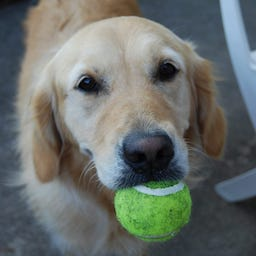

In [12]:
dog

In [14]:
clf = imgclf.ImageClassifier()

clf.proba2tuple(
    clf.predict_proba([dog_array]),
    labels_no=5
)

[[('tennis ball', 0.99284875, 852),
  ('golden retriever', 0.0067028664, 207),
  ('Labrador retriever', 0.00043766573, 208),
  ('racket', 4.7027543e-06, 752),
  ('Chesapeake Bay retriever', 2.9818214e-06, 209)]]

## Segmentation

### Default

In [77]:
fatf.setup_random_seed(42)

segmenter = fatf_segmentation.QuickShift(
    dog_array,
    ratio=0.2,      # 0.1
    kernel_size=5,  # 10
    max_dist=50)    # 30

22-Jul-07 20:11:21 fatf         INFO     Seeding RNGs using the input parameter.
22-Jul-07 20:11:21 fatf         INFO     Seeding RNGs with 42.


In [69]:
print(f'Number of segments: {segmenter.segments_number}')

Number of segments: 29


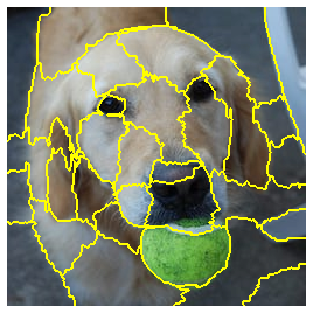

In [70]:
dog_segmented_default = segmenter.mark_boundaries(colour=(255, 255, 0))

imshow(dog_segmented_default)

In [71]:
plt.imsave('_figures/dog_segments_default.jpeg', dog_segmented_default)

### Custom

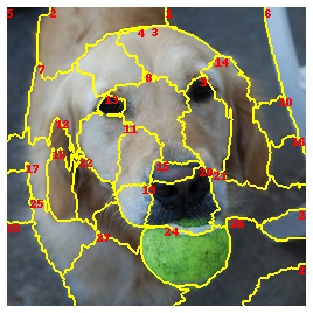

In [73]:
imshow(segmenter.number_segments(
    image=dog_segmented_default, colour=(255, 0, 0)))

In [119]:
# husky_segment_merge = [  # retriever
#     [23],  # ball
#     [13],  # left eye
#     [9],  # right eye
#     [19],  # nose
#     [18, 11, 8, 3, 14, 5],  # face
#     [0, 2, 7, 17, 24, 26, 21],  # body
#     [4, 12, 16, 27],  # left bg
#     [1, 6, 10, 15, 20, 22, 25, 28]  # right bg
# ]

dog_segment_merge = [               # RETRIEVER
    [24],                           # ball
    [13],                           # left eye
    [9],                            # right eye
    [15, 20],                       # nose
    [3, 4, 7, 8, 11, 14, 19],       # face
    [2, 25, 27],                    # body
    [5, 12, 17, 18, 22, 28],        # left bg
    [1, 6, 10, 16, 21, 23, 26, 29]  # right bg
]

_ = segmenter.merge_segments(dog_segment_merge, inplace=True)
segmenter.segments_number = len(dog_segment_merge)
print(f'Number of segments: {segmenter.segments_number}')

Number of segments: 8


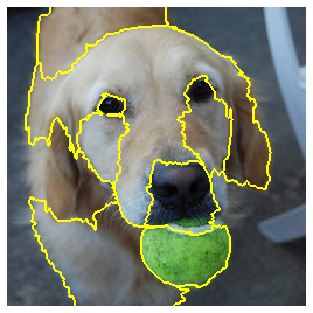

In [120]:
dog_segmented_custom = segmenter.mark_boundaries(colour=(255, 255, 0), )

imshow(dog_segmented_custom)

In [121]:
plt.imsave('_figures/dog_segments_custom.jpeg', dog_segmented_custom)

## Occlusion

In [122]:
occluder = fatf_occlusion.Occlusion(dog_array, segmenter.segments)

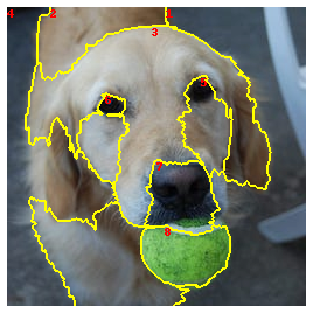

In [123]:
imshow(
    segmenter.number_segments(image=dog_segmented_custom, colour=(255, 0, 0))
)

In [124]:
occlusion_mask = np.zeros(segmenter.segments_number, dtype=np.int8)
occlusion_mask[7] = 1

### Mean

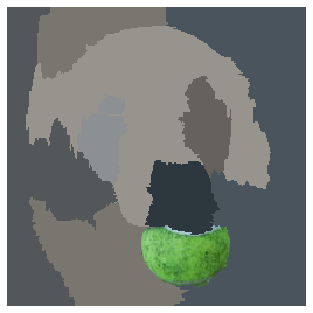

In [125]:
dog_occlusion_mean = occluder.occlude_segments_vectorised(
    occlusion_mask, colour='mean')

imshow(dog_occlusion_mean)

In [126]:
plt.imsave('_figures/dog_occlusion_mean.jpeg', dog_occlusion_mean)

In [132]:
print('Top 5 predictions:')
clf.proba2tuple(
    clf.predict_proba([dog_occlusion_mean]),
    labels_no=5
)

Top 5 predictions:


[[('skunk', 0.7289713, 361),
  ('tennis ball', 0.045593977, 852),
  ('Scotch terrier', 0.019499568, 199),
  ('ballpoint', 0.013535228, 418),
  ('space shuttle', 0.013096817, 812)]]

In [134]:
img_pred = clf.proba2tuple(
    clf.predict_proba([dog_occlusion_mean]), labels_no=1000)[0]
print('Dog predictions:')
find_dog_prediction(img_pred)

Dog predictions:


[('tennis ball', 0.045593977, 852),
 ('golden retriever', 3.7502756e-05, 207),
 ('Labrador retriever', 2.3095503e-05, 208)]

### Black

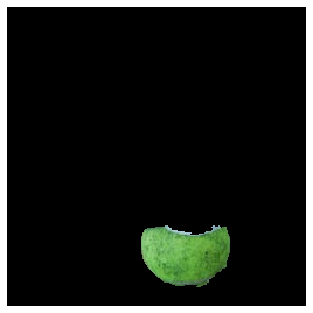

In [128]:
dog_occlusion_black = occluder.occlude_segments_vectorised(
    occlusion_mask, colour='black')

imshow(dog_occlusion_black)

In [129]:
plt.imsave('_figures/dog_occlusion_black.jpeg', dog_occlusion_black)

In [130]:
print('Top 5 predictions:')
clf.proba2tuple(
    clf.predict_proba([dog_occlusion_black]),
    labels_no=5
)

[[('acorn', 0.15269406, 988),
  ('mushroom', 0.096469775, 947),
  ('bolete', 0.05952108, 997),
  ('leafhopper', 0.05779011, 317),
  ('fig', 0.040960964, 952)]]

In [133]:
img_pred = clf.proba2tuple(
    clf.predict_proba([dog_occlusion_black]), labels_no=1000)[0]
print('Dog predictions:')
find_dog_prediction(img_pred)

Dog predictions:


[('tennis ball', 0.0013487719, 852),
 ('Labrador retriever', 0.00012538722, 208),
 ('golden retriever', 8.250726e-05, 207)]

## Linear Surrogate Explanation

In [169]:
SAMPLES_NO = 1000
GENERATE_FULL_SAMPLE = True

BATCH_SIZE = 100

OCCLUSION_COLOUR = 'black'

GET_TOP_N = 8

In [170]:
# Get occluder with the desired colour
occluder_bk = fatf_occlusion.Occlusion(
    dog_array, segmenter.segments, colour=OCCLUSION_COLOUR)

# Generate sample
if GENERATE_FULL_SAMPLE:
    sampled_data = np.array(list(itertools.product(
        [0, 1], repeat=segmenter.segments_number)))
else:
    fatf.setup_random_seed(42)
    sampled_data = fatf_augmentation.random_binary_sampler(
        segmenter.segments_number, SAMPLES_NO)

# Convert to images and predict (in batches)
iter_ = fatf_processing.batch_data(
    sampled_data,
    batch_size=BATCH_SIZE,
    transformation_fn=occluder_bk.occlude_segments_vectorised)

sampled_data_probabilities = []
for batch in iter_:
    sampled_data_probabilities.append(
        clf.predict_proba(batch))
sampled_data_probabilities = np.vstack(sampled_data_probabilities)

In [174]:
# Get linear explanation
def get_linear(class_id, top_features=5):
    class_probs = sampled_data_probabilities[:, class_id]

    model = sklearn.linear_model.Ridge(
        alpha=1, fit_intercept=True, random_state=42)
    model.fit(sampled_data, class_probs)  # sample_weight

    feature_ordering = np.flip(np.argsort(np.abs(model.coef_)))
    top_features = feature_ordering[:top_features]
    # Add 1 since segment count starts at 1 and not at 0
    top_features_ = top_features + 1

    explanation = list(zip(top_features_, model.coef_[top_features]))

    return model, explanation

# Visualise explanation -- image
def visualise_img(explanation):
    highlight_mask = []
    for i, v in explanation:
        c = (255, 0, 0) if v < 0 else (0, 255, 0)
        c_ = 'red' if v < 0 else 'green'
        highlight_mask.append((i, v, c, c_))
    highlight_mask = sorted(
        highlight_mask, key=lambda i: abs(i[1]), reverse=True)

    seg, col = [], []
    for s, _, c, _ in highlight_mask[:GET_TOP_N]:
        seg.append(int(s))
        col.append(c)

    _explanation = segmenter.highlight_segments(seg, colour=col)
    _explanation_ = segmenter.mark_boundaries(
        image=_explanation, colour=(255, 255, 0))
    
    return _explanation_

### Tennis Ball

In [184]:
class_name = 'tennis ball'
class_id = IDS[class_name]

model, explanation = get_linear(class_id, top_features=GET_TOP_N)

explanation

[(8, 0.4963130831334506),
 (7, 0.15040978204660238),
 (3, 0.1296071664737198),
 (1, 0.11830377300995172),
 (2, 0.09416431448818406),
 (6, -0.03124385300421859),
 (5, -0.019758174765508448),
 (4, -0.010845112287120123)]

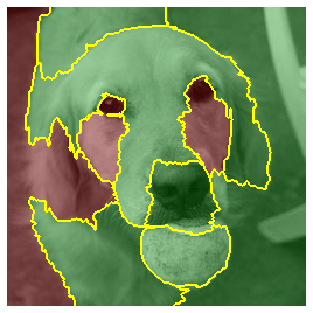

In [181]:
explanation_ = visualise_img(explanation)

imshow(explanation_)

plt.imsave(f'_figures/explanation_{class_name.replace(" ", "-")}_lime_img.pdf',  # jpeg
           explanation_)

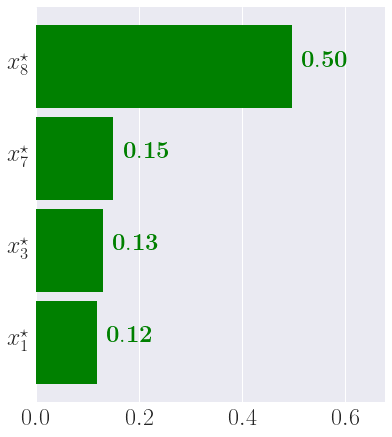

In [186]:
# fontsize=14 # labelsize=16
# xlim = (-0.001, 0.017) # xlim = (-0.01, 0.76)
plot_bar_exp(
    explanation,
    savepath=f'_figures/explanation_{class_name.replace(" ", "-")}_lime_bar.pdf',
    onesided=True,
    feature_no=4,
    label_fmt='\\(x_{{{:d}}}^\star\\)')

### Golden Retriever

In [187]:
class_name = 'golden retriever'
class_id = IDS[class_name]

model, explanation = get_linear(class_id, top_features=GET_TOP_N)

explanation

[(3, 0.3701883997333127),
 (8, -0.18124355492813873),
 (5, 0.13277802090102098),
 (4, 0.13055524530691712),
 (6, 0.06920064156908988),
 (1, -0.024123211625851272),
 (2, 0.023408522017753668),
 (7, -0.015535436417646825)]

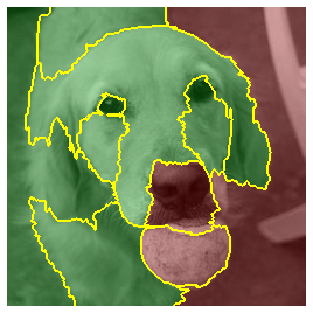

In [188]:
explanation_ = visualise_img(explanation)

imshow(explanation_)

plt.imsave(f'_figures/explanation_{class_name.replace(" ", "-")}_lime_img.pdf',  # jpeg
           explanation_)

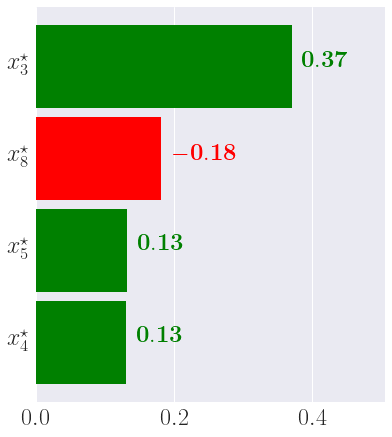

In [189]:
plot_bar_exp(
    explanation,
    savepath=f'_figures/explanation_{class_name.replace(" ", "-")}_lime_bar.pdf',
    onesided=True,
    feature_no=4,
    label_fmt='\\(x_{{{:d}}}^\star\\)')

### Labrador Retriever

In [190]:
class_name = 'Labrador retriever'
class_id = IDS[class_name]

model, explanation = get_linear(class_id, top_features=GET_TOP_N)

explanation

[(3, 0.13945965110678532),
 (4, -0.09134022788152264),
 (1, -0.05412111866107334),
 (2, -0.05181749503348677),
 (6, 0.04824751235608286),
 (8, -0.043275561462901097),
 (7, 0.031187667396189386),
 (5, 0.021770166770645662)]

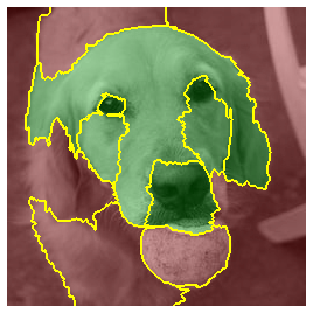

In [191]:
explanation_ = visualise_img(explanation)

imshow(explanation_)

plt.imsave(f'_figures/explanation_{class_name.replace(" ", "-")}_lime_img.pdf',  # jpeg
           explanation_)

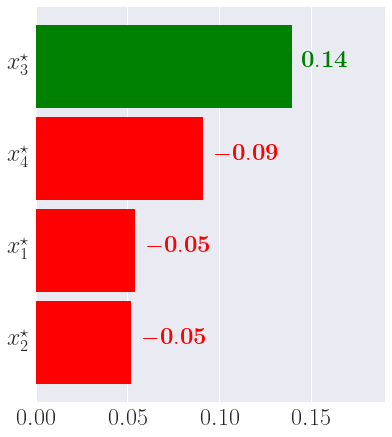

In [192]:
plot_bar_exp(
    explanation,
    savepath=f'_figures/explanation_{class_name.replace(" ", "-")}_lime_bar.pdf',
    onesided=True,
    feature_no=4,
    label_fmt='\\(x_{{{:d}}}^\star\\)')


## Tree Surrogate Explanation

In [161]:
# TODO